In [1]:
import timeit
from pathlib import Path
import re
import sys
sys.path.append(str(Path.cwd().parent / "classes"))
sys.path.append(str(Path.cwd().parent))

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

from sim_config import SimConfiguration
from simulation import Simulation
from msa import Msa


TREES_PATH = Path.cwd() / "TRUE_TREES"


In [27]:
def scale_tree(tree_path: str, scale_factor: float, overwrite: bool=False):
    # Read the tree
    tree_path = Path(tree_path)

    with open(tree_path, 'r') as f:
        newick_str = f.read().strip()
    
    # Function to scale branch lengths in Newick string
    def scale_length(match):
        length = float(match.group(1))
        scaled = length * scale_factor
        return f":{scaled:.10f}"
    
    # Scale all branch lengths using regex
    scaled_newick = re.sub(r':([0-9.]+)', scale_length, newick_str)

    scaled_tree_path = (tree_path.parent / f"scaled_{scale_factor}.tree") if not overwrite else tree_path
    # Write the scaled tree directly
    with open(scaled_tree_path, 'w') as f:
        f.write(scaled_newick)
    return scaled_tree_path

# for tree_path in list(TREES_PATH.iterdir()):#[0.5, 1,2,4,8,16]:
#     scale_tree(str(tree_path), 10, True)


In [36]:
def refresh_sim(tree_file):
    ROOT_SEQUENCE_LENGTH = 50

    sim_config = SimConfiguration(original_sequence_length=ROOT_SEQUENCE_LENGTH, indel_length_alpha=2.0,
                                indel_truncated_length=50,
                                rate_ins=0.03, rate_del=0.09,
                                deletion_extra_edge_length=50,
                                switch_factor=200,
                                seed=111)
    sim = Simulation(input_tree=str(tree_file), config=sim_config)
    return sim
time_labels = ["tree", "hybrid", "blocktree", "blocklist", "naive"]


In [37]:

time_winners = []
measured_times: list[list[float]] = []





for tree_path in list(TREES_PATH.iterdir()):#[0.5, 1,2,4,8,16]:
    sim = refresh_sim(tree_path)
    hybrid_time = 1000#timeit.timeit(sim.msa_from_hybrid, number=5)
    blocklist_time = timeit.timeit(sim.msa_from_blocklist, number=1)
    blocktree_time = timeit.timeit(sim.msa_from_blocktree, number=1)
    naive_time = timeit.timeit(sim.msa_from_naive, number=1)

    time_measures = [tree_path, hybrid_time, blocktree_time, blocklist_time, naive_time]
    print(time_measures)
    measured_times.append(time_measures)



[PosixPath('/home/pupkolab/Dev/evo-sim/benchmark/TRUE_TREES/ELAVL2_true_tree.txt'), 1000, 0.0024178620001293893, 0.002270836999969106, 0.0018958469997869543]
[PosixPath('/home/pupkolab/Dev/evo-sim/benchmark/TRUE_TREES/CHMP4C_true_tree.txt'), 1000, 0.006004251000149452, 0.004531883000026937, 0.00433821399997214]
[PosixPath('/home/pupkolab/Dev/evo-sim/benchmark/TRUE_TREES/LCP1_true_tree.txt'), 1000, 0.0071224099999653845, 0.006572578000032081, 0.0040785520000099496]
[PosixPath('/home/pupkolab/Dev/evo-sim/benchmark/TRUE_TREES/OGFOD1_true_tree.txt'), 1000, 0.006553380000013931, 0.0064594420000503305, 0.0016877420000582788]
[PosixPath('/home/pupkolab/Dev/evo-sim/benchmark/TRUE_TREES/BRPF1_true_tree.txt'), 1000, 0.0066905419998875, 0.0024667699999554316, 0.0017689169999357546]
[PosixPath('/home/pupkolab/Dev/evo-sim/benchmark/TRUE_TREES/MTMR2_true_tree.txt'), 1000, 0.0022736390001227846, 0.0022660130000531353, 0.0015449580000677088]
[PosixPath('/home/pupkolab/Dev/evo-sim/benchmark/TRUE_TREES/

In [15]:
%%timeit
for tree_path in list(TREES_PATH.iterdir()):#[0.5, 1,2,4,8,16]:
    sim = refresh_sim(tree_path / "raxml.tree")
    sim.msa_from_blocklist()


5.94 s ± 110 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%%timeit
for tree_path in list(TREES_PATH.iterdir()):#[0.5, 1,2,4,8,16]:
    sim = refresh_sim(tree_path / "raxml.tree")
    sim.msa_from_blocktree()

6.23 s ± 67.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%%timeit
for tree_path in list(TREES_PATH.iterdir()):#[0.5, 1,2,4,8,16]:
    sim = refresh_sim(tree_path / "raxml.tree")
    sim.msa_from_hybrid()

5.84 s ± 82.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
times_df = pd.DataFrame(measured_times, columns=time_labels).reset_index()

# times_df.idxmin(axis=1).value_counts()
times_df.loc[(times_df.blocklist - times_df.hybrid).abs().idxmax()].to_list()

[np.int64(452),
 PosixPath('/home/pupkolab/Dev/evo-sim/benchmark/TRUE_TREES/SGCE_true_tree.txt'),
 np.int64(1000),
 np.float64(0.001979209999944942),
 np.float64(0.0016746510000302806),
 np.float64(0.0014942020000034972)]

In [39]:
times_df.to_csv("all_methods_comparison_50.csv")

In [43]:
times_df_50 = pd.read_csv("all_methods_comparison_50.csv", index_col=0)
times_df_50["Root length"] = 50
times_df_100 = pd.read_csv("all_methods_comparison_100.csv", index_col=0)
times_df_100["Root length"] = 100
times_df_500 = pd.read_csv("all_methods_comparison_500.csv", index_col=0)
times_df_500["Root length"] = 500
times_df_1000 = pd.read_csv("all_methods_comparison_1000.csv", index_col=0)
times_df_1000["Root length"] = 1000

times_df = pd.concat([times_df_50, times_df_100, times_df_500, times_df_1000])

list_of_rows = []
for idx, row in times_df.iterrows():
    list_of_rows.append({
        "Root length": row["Root length"],
        "Score type": 'blocklist',
        "Time": row['blocklist']
    })
    list_of_rows.append({
        "Root length": row["Root length"],
        "Score type": 'blocktree',
        "Time": row['blocktree']
    })
    list_of_rows.append({
        "Root length": row["Root length"],
        "Score type": 'naive',
        "Time": row['naive']
    })

df_scores = pd.DataFrame(list_of_rows)

In [44]:
df_scores["Time [ms]"] = df_scores["Time"]*1000

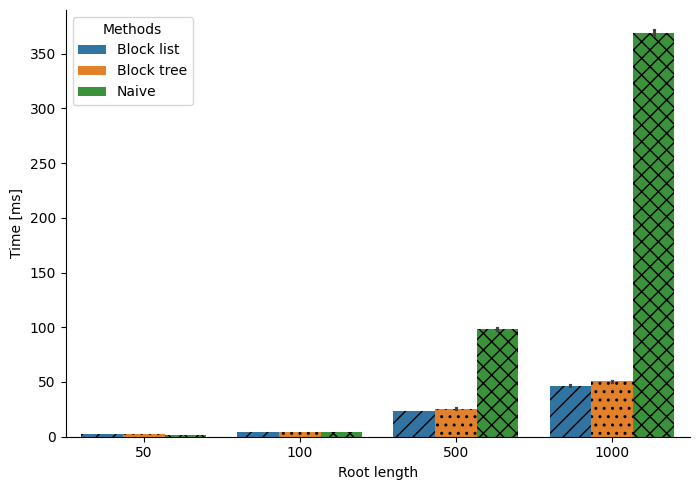

In [45]:
ax = sns.barplot(data=df_scores, x="Root length", y="Time [ms]", hue="Score type")
ax.figure.set_size_inches(7.1, 5)
sns.despine()
hatches = ['//', '//', '//','//', 
           '..', '..', '..', '..', 
           'xx', 'xx', 'xx', 'xx',
            '//','..', 'xx']
# Loop over the bars
handles, old_labels = ax.get_legend_handles_labels()
new_labels = ['Block list', 'Block tree', 'Naive']  # Your custom labels here
plt.legend(handles, new_labels, title='Methods')

for i,thisbar in enumerate(ax.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])

plt.tight_layout()
plt.savefig("assets/orthomam_benchmark_root_length.svg",bbox_inches="tight", dpi=300)
plt.savefig("assets/orthomam_benchmark_root_length.png",bbox_inches="tight", dpi=300)



In [46]:
times_df.iloc[:,2:].idxmin(axis=1).value_counts()


blocklist    1359
naive         556
blocktree     249
Name: count, dtype: int64

In [47]:
times_df_50.describe()

,index,hybrid,blocktree,blocklist,naive,Root length
count,541.000000,541.0,541.000000,541.000000,541.000000,541.0
mean,270.000000,1000.0,0.002519,0.002229,0.001661,50.0
std,156.317519,0.0,0.000772,0.000666,0.000488,0.0
min,0.000000,1000.0,0.001768,0.001675,0.001155,50.0
25%,135.000000,1000.0,0.002085,0.001871,0.001385,50.0
50%,270.000000,1000.0,0.002242,0.001995,0.001497,50.0
75%,405.000000,1000.0,0.002630,0.002293,0.001712,50.0
max,540.000000,1000.0,0.007122,0.006573,0.004338,50.0


In [49]:
# stats.f_oneway(times_df["naive"], times_df["blocktree"], times_df["blocklist"], times_df["hybrid"])
stats.f_oneway(times_df_50["blocktree"], times_df_50["blocklist"], times_df_50["naive"])

# tuk = stats.tukey_hsd(times_df_50["naive"], times_df_50["blocklist"], times_df_50["blocktree"])
# print(tuk)

F_onewayResult(statistic=np.float64(242.17276480909254), pvalue=np.float64(9.601739450386914e-93))